# Supervised Learning
>Train a `sklearn.ensemble.RandomForestClassifier` that given a soccer player description outputs his skin color. Show how different parameters passed to the Classifier affect the overfitting issue. Perform cross-validation to mitigate the overfitting of your model. Once you assessed your model, inspect the feature\_importances\_ attribute and discuss the obtained results. With different assumptions on the data (e.g., dropping certain features even before feeding them to the classifier), can you obtain a substantially different feature_importances_ attribute?

> *BONUS:* plot the learning curves against at least 2 different sets of parameters passed to your Random Forest. To obtain smooth curves, partition your data in at least 20 folds. Can you find a set of parameters that leads to high bias, and one which does not?

From the preprocessing step, we generated 6 datasets, that we will use with our machine learning algorithm. We will later on compare the results we obtain. As a reminder, the 6 datasets are as follows
1.  3 datasets with NaNs and 3 without NaNs

2.  1. players.csv -> Simply the players, no added cross-features
    2. players_with features.csv -> Added cross-features.
    3. players_with features_only_num_values.csv -> We do not consider the textual fields.

In [5]:
# Import Libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import sklearn
import sklearn.ensemble
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
%matplotlib inline
%load_ext autoreload
%autoreload 2

# There's a lot of columns in the DF. 
# Therefore, we add this option so that we can see more columns
pd.options.display.max_columns = 100

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Given a file, loads the features the way we need them to pass them to the `RandomForestClassifier` method. We also prepare the output labels : first of all, we do a binary classification, setting the limit at 0.5, in order to have a simple case to treat. We return as well the columns vector, which corresponds to the features we're dealing with.

In [6]:
def prepare_features_binary(file_):
    df = pd.read_csv(file_)

    # We drop the skin colour as it is the solution, it goes into the output array.
    X = df.drop('skin_colour',axis=1)
    columns = X.columns.values
    Y = np.array(df['skin_colour'])
    # Binary classification performed here.
    Y = (Y>=0.5).astype(int)
    
    #Y = np.multiply(8,np.array(df['skin_colour'])).astype(int)
    #entries = np.multiply(8.,np.array(df['skin_colour'].unique())).astype(int)
    
    #Y_multi = np.zeros((X.shape[0],len(entries)))
    #for index, entry in enumerate(Y):
    #    Y_multi[index,entry] = 1.
    return X, Y, columns
X,Y,columns = prepare_features_binary('Data/players_with features_no_nan_only_num_values2.csv')
print(columns)

['height' 'weight' 'games' 'victories' 'ties' 'defeats' 'goals'
 'yellowCards' 'yellowReds' 'redCards' 'gravity' 'meanIAT_yellowCards'
 'meanIAT_yellowReds' 'meanIAT_redCards' 'meanIAT_gravity'
 'meanExp_yellowCards' 'meanExp_yellowReds' 'meanExp_redCards'
 'meanExp_gravity' 'english' 'german' 'french' 'spanish' 'birthYear']


Our classifier is a Random Forest. The [cross_validation module of scikit-learn](http://scikit-learn.org/0.17/modules/generated/sklearn.cross_validation.cross_val_score.html) allows us to test the performance of our classification. The `cv` field allows us to chose the k-fold cross-validation we want to perform.

Cross Validation result  0.749828298412
Feature ranking:
1. feature 3 - victories (0.078298)
2. feature 14 - meanIAT_gravity (0.070582)
3. feature 6 - goals (0.063658)
4. feature 15 - meanExp_yellowCards (0.059060)
5. feature 11 - meanIAT_yellowCards (0.056030)
6. feature 7 - yellowCards (0.055581)
7. feature 2 - games (0.054121)
8. feature 18 - meanExp_gravity (0.051945)
9. feature 4 - ties (0.048499)
10. feature 5 - defeats (0.048394)
11. feature 23 - birthYear (0.045755)
12. feature 1 - weight (0.044270)
13. feature 10 - gravity (0.043781)
14. feature 21 - french (0.043488)
15. feature 0 - height (0.043312)
16. feature 17 - meanExp_redCards (0.034819)
17. feature 13 - meanIAT_redCards (0.032369)
18. feature 16 - meanExp_yellowReds (0.031411)
19. feature 12 - meanIAT_yellowReds (0.027207)
20. feature 9 - redCards (0.018343)
21. feature 19 - english (0.013824)
22. feature 20 - german (0.013373)
23. feature 8 - yellowReds (0.011841)
24. feature 22 - spanish (0.010037)


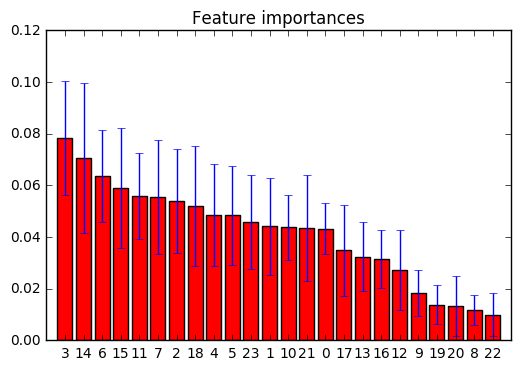

In [7]:
def cross_validation_feature_importances(X,Y,columns,cv): 
    forest = RandomForestClassifier()
    print('Cross Validation result ', cross_val_score(forest,X,Y,cv = 5).mean())
    
    forest = forest.fit(X,Y)
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
    indices = np.argsort(importances)[::-1]
    # Print the feature ranking
    print("Feature ranking:")

    for f in range(X.shape[1]):
        print("%d. feature %d - %s (%f)" % (f + 1, indices[f],  columns[indices[f]], importances[indices[f]]))

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), indices)
    plt.xlim([-1, X.shape[1]])
    plt.show()

cross_validation_feature_importances(X,Y,columns,5)

This 5-fold cross validation shows that our algorithm predicts 75 % of the time the correct skin. We want to then visualise what are the most important features in the decision, taking the example of the feature importances with trees from [scikit-learn](http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html).

It seems that even if no feature is really significantly better at predicting the skin colour of a player, the ones we defined in the preprocessing that related the referee and the player seem to be able to perform a bit better. It might mean that some referee might have some bias towards the coloured players, and the features we defined from this bias help us identify the skin colour. The first feature is the *meanExp_yellowCards*, which cross_features the referees with which the player played with the number of yellow cards received from them, weighted by the *mean explicit bias score*, which tells us if a referee is warmer towards coloured people of not.

Let us now visualise the result we'd get when we would not have added the supplementary features.

In [9]:
X_no_ft,Y_no_ft,columns_no_ft = prepare_features_binary('Data/players_no_nan_only_num_values2.csv')
cross_validation_feature_importances(X_no_ft,Y_no_ft,columns_no_ft,5)

OSError: File b'Data/players_no_nan_only_num_values2.csv' does not exist

TODO : Comparison - How to do when you have less features ?